In [ ]:
!pip install xgboost scikit-learn pandas pyarrow joblib

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("📊 Loading data...")

# Load parquet files (much faster than CSV)
train_df = pd.read_parquet('/content/drive/MyDrive/seoul_bikes/netflow_features_6m_train.parquet')
test_df = pd.read_parquet('/content/drive/MyDrive/seoul_bikes/netflow_features_6m_test.parquet')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nDate range:")
print(f"Train: {train_df['flow_date'].min()} to {train_df['flow_date'].max()}")
print(f"Test: {test_df['flow_date'].min()} to {test_df['flow_date'].max()}")

# Check for data quality
print(f"\nMissing target values:")
print(f"Train: {train_df['target_net_flow_2h'].isna().sum()}")
print(f"Test: {test_df['target_net_flow_2h'].isna().sum()}")


📊 Loading data...
Train shape: (370209, 55)
Test shape: (33642, 55)

Date range:
Train: 2025-01-09 to 2025-06-16
Test: 2025-06-17 to 2025-06-30

Missing target values:
Train: 0
Test: 0


In [ ]:
exclude_cols = [
    'station_id', 'flow_date', 'flow_hour',
    'bikes_departed', 'bikes_arrived', 'net_flow', 'total_activity',
    'target_net_flow_2h', 'day_of_week', 'is_weekend', 'season',
    'avg_trip_duration_min', 'avg_trip_distance_m'
]

feature_cols = [col for col in train_df.columns
                if col not in exclude_cols
                and train_df[col].dtype in ['int64', 'float64', 'int32', 'float32']]

print(f"Number of features: {len(feature_cols)}")
print("\nFeature categories:")
print(f"- Lag features: {len([f for f in feature_cols if 'lag' in f])}")
print(f"- Rolling features: {len([f for f in feature_cols if 'roll' in f])}")
print(f"- Time features: {len([f for f in feature_cols if any(t in f for t in ['hour', 'dow', 'rush'])])}")
print(f"- Station features: {len([f for f in feature_cols if 'station' in f])}")

# Prepare final datasets
X_train = train_df[feature_cols]
y_train = train_df['target_net_flow_2h']
X_test = test_df[feature_cols]
y_test = test_df['target_net_flow_2h']

# Remove any remaining NaN
train_mask = ~(X_train.isna().any(axis=1) | y_train.isna())
test_mask = ~(X_test.isna().any(axis=1) | y_test.isna())

X_train = X_train[train_mask]
y_train = y_train[train_mask]
X_test = X_test[test_mask]
y_test = y_test[test_mask]

print(f"\nFinal dataset sizes:")
print(f"Train: {len(X_train):,}")
print(f"Test: {len(X_test):,}")

Number of features: 42

Feature categories:
- Lag features: 16
- Rolling features: 12
- Time features: 6
- Station features: 3

Final dataset sizes:
Train: 259,349
Test: 33,642


In [ ]:
print("\n🚀 Training XGBoost Model with GPU...")

# Check if GPU is available
import subprocess
try:
    subprocess.check_output('nvidia-smi')
    use_gpu = True
    print("✅ GPU detected! Using GPU acceleration")
except:
    use_gpu = False
    print("⚠️ No GPU detected, using CPU")

# Configure XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist' if use_gpu else 'hist',  # GPU acceleration
    'predictor': 'gpu_predictor' if use_gpu else 'cpu_predictor',
    'max_depth': 10,
    'learning_rate': 0.03,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'min_child_weight': 5,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'early_stopping_rounds': 50,
    'eval_metric': 'rmse'
}

# Time series cross-validation
print("\n📊 Running time series cross-validation...")
tscv = TimeSeriesSplit(n_splits=3)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    print(f"\nFold {fold + 1}:")

    X_fold_train = X_train.iloc[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train.iloc[val_idx]
    y_fold_val = y_train.iloc[val_idx]

    # Train on fold
    fold_model = xgb.XGBRegressor(**params)
    fold_model.fit(
        X_fold_train, y_fold_train,
        eval_set=[(X_fold_val, y_fold_val)],
        verbose=False
    )

    # Evaluate
    val_pred = fold_model.predict(X_fold_val)
    mae = mean_absolute_error(y_fold_val, val_pred)
    r2 = r2_score(y_fold_val, val_pred)
    cv_scores.append({'mae': mae, 'r2': r2})
    print(f"  MAE: {mae:.3f}, R²: {r2:.3f}")

print(f"\nAverage CV Performance:")
print(f"  MAE: {np.mean([s['mae'] for s in cv_scores]):.3f} ± {np.std([s['mae'] for s in cv_scores]):.3f}")
print(f"  R²: {np.mean([s['r2'] for s in cv_scores]):.3f} ± {np.std([s['r2'] for s in cv_scores]):.3f}")

# Train final model on full training set
print("\n🎯 Training final model on full dataset...")
model = xgb.XGBRegressor(**params)

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=True
)

print(f"\n✅ Training complete!")
print(f"Best iteration: {model.best_iteration}")


🚀 Training XGBoost Model with GPU...
✅ GPU detected! Using GPU acceleration

📊 Running time series cross-validation...

Fold 1:
  MAE: 3.336, R²: 0.433

Fold 2:
  MAE: 3.751, R²: 0.508

Fold 3:
  MAE: 3.692, R²: 0.586

Average CV Performance:
  MAE: 3.593 ± 0.183
  R²: 0.509 ± 0.063

🎯 Training final model on full dataset...
[0]	validation_0-rmse:7.10595	validation_1-rmse:8.01541
[1]	validation_0-rmse:7.01091	validation_1-rmse:7.91055
[2]	validation_0-rmse:6.93904	validation_1-rmse:7.83671
[3]	validation_0-rmse:6.84786	validation_1-rmse:7.73618
[4]	validation_0-rmse:6.75887	validation_1-rmse:7.63753
[5]	validation_0-rmse:6.69097	validation_1-rmse:7.56090
[6]	validation_0-rmse:6.61797	validation_1-rmse:7.47793
[7]	validation_0-rmse:6.53877	validation_1-rmse:7.39159
[8]	validation_0-rmse:6.48305	validation_1-rmse:7.33438
[9]	validation_0-rmse:6.40639	validation_1-rmse:7.24896
[10]	validation_0-rmse:6.33235	validation_1-rmse:7.16901
[11]	validation_0-rmse:6.27290	validation_1-rmse:7.1042

In [ ]:
print("\n📈 Model Evaluation")
print("="*60)

# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Calculate metrics
metrics = {
    'train': {
        'mae': mean_absolute_error(y_train, train_pred),
        'rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
        'r2': r2_score(y_train, train_pred)
    },
    'test': {
        'mae': mean_absolute_error(y_test, test_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
        'r2': r2_score(y_test, test_pred)
    }
}

print("Performance Metrics:")
print(f"{'Metric':<10} {'Train':<10} {'Test':<10}")
print("-"*30)
for metric in ['mae', 'rmse', 'r2']:
    print(f"{metric.upper():<10} {metrics['train'][metric]:<10.3f} {metrics['test'][metric]:<10.3f}")

# Analyze errors by hour
test_analysis = test_df[test_mask].copy()
test_analysis['prediction'] = test_pred
test_analysis['error'] = np.abs(test_analysis['target_net_flow_2h'] - test_analysis['prediction'])

hourly_mae = test_analysis.groupby('flow_hour')['error'].mean().sort_values(ascending=False)
print(f"\n⏰ Worst performing hours:")
print(hourly_mae.head())

# Station analysis
station_performance = test_analysis.groupby('station_id').agg({
    'error': ['mean', 'count']
}).round(3)
station_performance.columns = ['mae', 'predictions']
station_performance = station_performance[station_performance['predictions'] >= 20]
print(f"\n🚉 Worst performing stations (min 20 predictions):")
print(station_performance.sort_values('mae', ascending=False).head(10))


📈 Model Evaluation
Performance Metrics:
Metric     Train      Test      
------------------------------
MAE        2.070      3.442     
RMSE       2.862      5.062     
R2         0.842      0.611     

⏰ Worst performing hours:
flow_hour
6     6.160718
16    5.813654
5     5.147383
15    5.139069
17    4.563503
Name: error, dtype: float64

🚉 Worst performing stations (min 20 predictions):
              mae  predictions
station_id                    
X           5.857          325
ST-2045     5.724          296
ST-2033     5.480          283
ST-3251     5.421          199
ST-2574     5.268          287
ST-2050     5.138          302
ST-2031     5.065          325
ST-891      5.033          297
ST-3300     4.965          246
ST-99       4.620          322


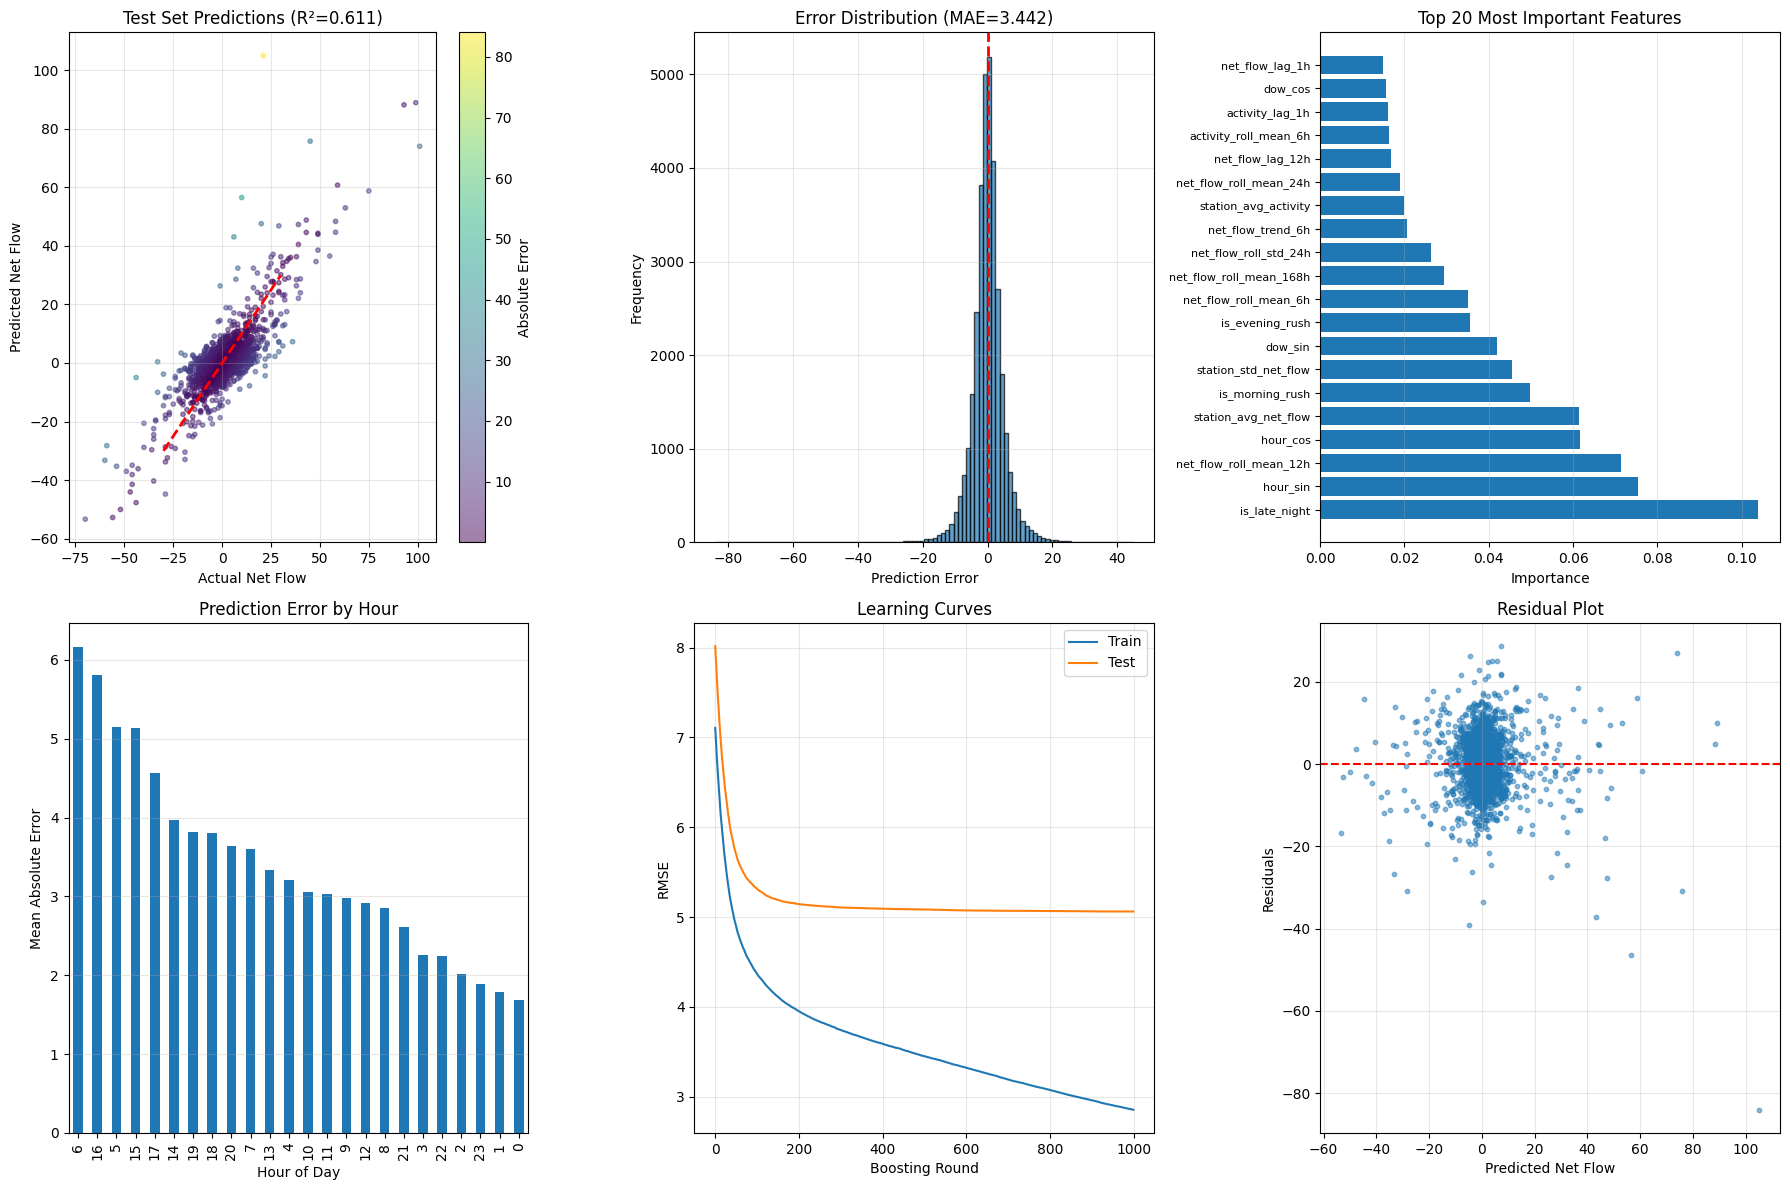

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Predictions vs Actual
ax = axes[0, 0]
sample_size = min(5000, len(test_pred))
idx = np.random.choice(len(test_pred), sample_size, replace=False)
scatter = ax.scatter(y_test.iloc[idx], test_pred[idx],
                    alpha=0.5, s=10, c=np.abs(y_test.iloc[idx] - test_pred[idx]),
                    cmap='viridis')
ax.plot([-30, 30], [-30, 30], 'r--', lw=2)
ax.set_xlabel('Actual Net Flow')
ax.set_ylabel('Predicted Net Flow')
ax.set_title(f'Test Set Predictions (R²={metrics["test"]["r2"]:.3f})')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Absolute Error')

# 2. Error Distribution
ax = axes[0, 1]
errors = y_test - test_pred
ax.hist(errors, bins=100, edgecolor='black', alpha=0.7)
ax.axvline(x=0, color='red', linestyle='--', lw=2)
ax.set_xlabel('Prediction Error')
ax.set_ylabel('Frequency')
ax.set_title(f'Error Distribution (MAE={metrics["test"]["mae"]:.3f})')
ax.grid(True, alpha=0.3)

# 3. Feature Importance (Top 20)
ax = axes[0, 2]
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

ax.barh(range(len(importance_df)), importance_df['importance'])
ax.set_yticks(range(len(importance_df)))
ax.set_yticklabels(importance_df['feature'], fontsize=8)
ax.set_xlabel('Importance')
ax.set_title('Top 20 Most Important Features')
ax.grid(True, alpha=0.3, axis='x')

# 4. Hourly Performance
ax = axes[1, 0]
hourly_mae.plot(kind='bar', ax=ax)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Prediction Error by Hour')
ax.grid(True, alpha=0.3, axis='y')

# 5. Learning Curves
ax = axes[1, 1]
results = model.evals_result()
ax.plot(results['validation_0']['rmse'], label='Train')
ax.plot(results['validation_1']['rmse'], label='Test')
ax.set_xlabel('Boosting Round')
ax.set_ylabel('RMSE')
ax.set_title('Learning Curves')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Residual Plot
ax = axes[1, 2]
residuals = y_test - test_pred
ax.scatter(test_pred[idx], residuals.iloc[idx], alpha=0.5, s=10)
ax.axhline(y=0, color='red', linestyle='--')
ax.set_xlabel('Predicted Net Flow')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/seoul_bikes/netflow_model_analysis.png', dpi=300, bbox_inches='tight')
plt.show()